<a href="https://www.kaggle.com/code/dsptlp/faceemotion-fer-2013?scriptVersionId=162555768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Packages

In [1]:
import os
import random
import shutil
import time
import warnings
import json
import timm
import wandb
from datetime import timedelta
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

import boto3
from botocore.exceptions import NoCredentialsError
from torch.utils.data.sampler import SubsetRandomSampler

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torch.distributed as dist
from torch.cuda.amp import autocast,GradScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

import timm
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler

from timm.scheduler.step_lr import StepLRScheduler

from tqdm import tqdm_notebook as tqdm

import timm
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from timm.scheduler.plateau_lr import PlateauLRScheduler

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error,accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# EDA

In [2]:
TRAINDIR="/kaggle/input/fer2013/train"
VALDIR="/kaggle/input/fer2013/test"
IMAGES = 20

In [3]:
classes_train = os.listdir(TRAINDIR)
classes_valid = os.listdir(VALDIR)

print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

Train Classes - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Validation Classes - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


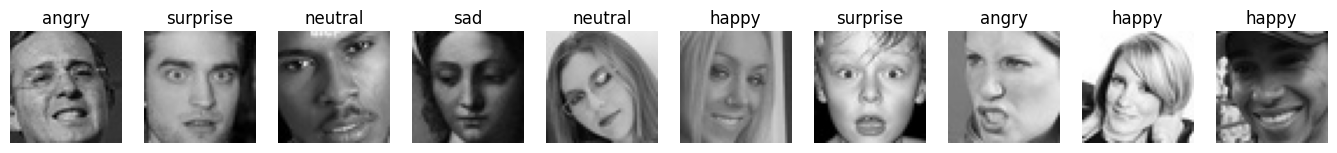

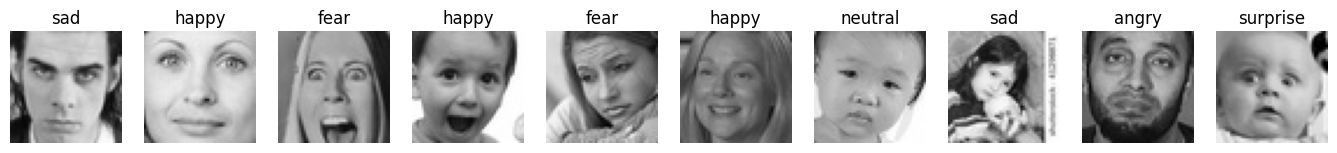

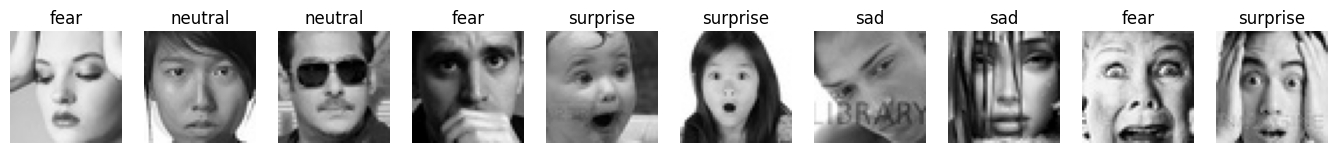

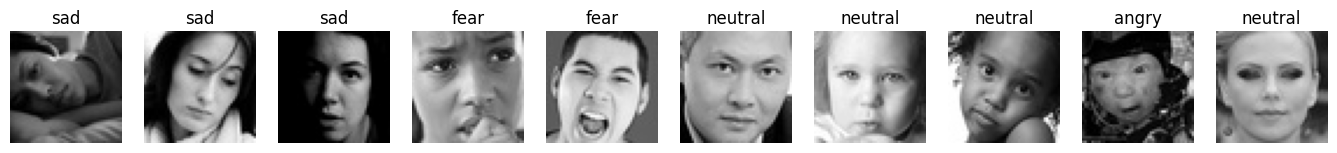

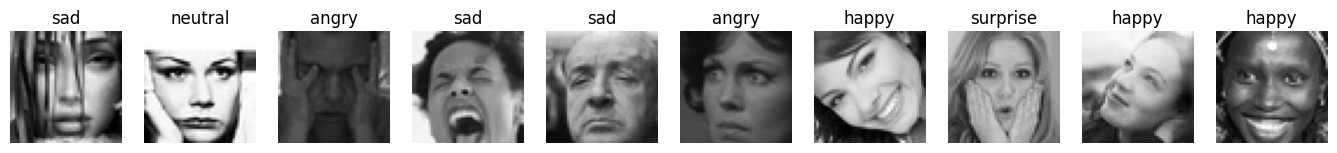

In [4]:
data_dir = TRAINDIR

test_transforms = transforms.Compose([transforms.ToTensor(),])

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    images, labels = next(iter(loader))  # Get the first batch of data   
    return images, labels, classes
        
counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        sub.set_title(classes[res] )
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

# MODEL TRAIN

In [5]:
GPU=0
SEED=1
ARCH = 'resnet50'
EPOCHS = 400
START_EPOCH = 0
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.5
PRINT_FREQ = 10
TRAIN_BATCH= 6000
imagesize = 244
VAL_BATCH=TRAIN_BATCH
WORKERS=2
use_autocast = True
LR_EPOCH_DROP = 50

In [6]:
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = False
cudnn.benchmark = True

In [7]:
print(torch.__version__)

2.0.0


In [8]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # Grad Scaler
    scaler = GradScaler()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)

        # compute output
        with autocast():
          output = model(images)
          loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # use the scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

In [9]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return top1.avg

In [10]:
def save_checkpoint(state, is_best, filename_in):
    #torch.save(state, filename_in)
    if is_best:
        torch.save(state, 'model_best.pth.tar')

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [12]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [13]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // LR_EPOCH_DROP))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [15]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 5)),    
    transforms.RandomInvert(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [16]:
train_dataset = datasets.ImageFolder(
    TRAINDIR, transform=transform_train)

In [17]:
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [18]:
val_dataset = datasets.ImageFolder(
    VALDIR, transform=transform_val)

In [19]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None)

In [20]:
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=VAL_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None) 

In [21]:
print(train_loader.dataset.classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [22]:
NUM_CLASSES = 7

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device",str(device))

model = timm.create_model(ARCH, pretrained = True, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Scheduler and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = timm.scheduler.StepLRScheduler(optimizer, decay_t = LR_EPOCH_DROP, decay_rate=WEIGHT_DECAY)

n_steps = len(train_loader.dataset)

Device cuda


In [23]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [24]:
%%time
best_acc1 = 0
best_epoch = 0
lrls = []
for epoch in range(START_EPOCH, EPOCHS):
    #adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    PATH = "M1_" +str(epoch) + "_acc1_" +str(acc1) + "_" + ARCH + ".tar" 
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best,PATH)
    
    scheduler.step(epoch + 1)
    lr_rate =  get_lr(optimizer)
    lrls.append(lr_rate)          
    print('lr: ' + str(lr_rate))

Epoch: [0][0/5]	Time 116.464 (116.464)	Data 34.621 (34.621)	Loss 1.9512e+00 (1.9512e+00)	Acc@1  14.57 ( 14.57)	Acc@5  71.73 ( 71.73)
Test: [0/2]	Time 40.565 (40.565)	Loss 1.9467e+00 (1.9467e+00)	Acc@1  17.68 ( 17.68)	Acc@5  86.77 ( 86.77)
 * Acc@1 17.554 Acc@5 86.877
lr: 0.01
Epoch: [1][0/5]	Time 11.178 (11.178)	Data  9.354 ( 9.354)	Loss 1.6233e+00 (1.6233e+00)	Acc@1  37.13 ( 37.13)	Acc@5  92.92 ( 92.92)
Test: [0/2]	Time  6.877 ( 6.877)	Loss 2.2484e+00 (2.2484e+00)	Acc@1  17.70 ( 17.70)	Acc@5  90.17 ( 90.17)
 * Acc@1 17.916 Acc@5 90.192
lr: 0.01
Epoch: [2][0/5]	Time 13.848 (13.848)	Data 12.050 (12.050)	Loss 1.3741e+00 (1.3741e+00)	Acc@1  47.55 ( 47.55)	Acc@5  95.78 ( 95.78)
Test: [0/2]	Time  7.362 ( 7.362)	Loss 2.0832e+00 (2.0832e+00)	Acc@1  25.93 ( 25.93)	Acc@5  87.65 ( 87.65)
 * Acc@1 25.606 Acc@5 87.559
lr: 0.01
Epoch: [3][0/5]	Time 12.934 (12.934)	Data 11.138 (11.138)	Loss 1.2415e+00 (1.2415e+00)	Acc@1  52.78 ( 52.78)	Acc@5  96.83 ( 96.83)
Test: [0/2]	Time  6.931 ( 6.931)	Loss 1.53

# RESULTS

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),                                      
                                     ])

In [27]:
def predict_image(image):
    
    model.eval()
    with torch.no_grad():
    
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
       
    return index

In [28]:
def get_random_images(num):
    data = datasets.ImageFolder(VALDIR, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    images, labels = next(iter(loader))  # Get the first batch of data   
    return images, labels, classes

<Figure size 1500x1500 with 0 Axes>

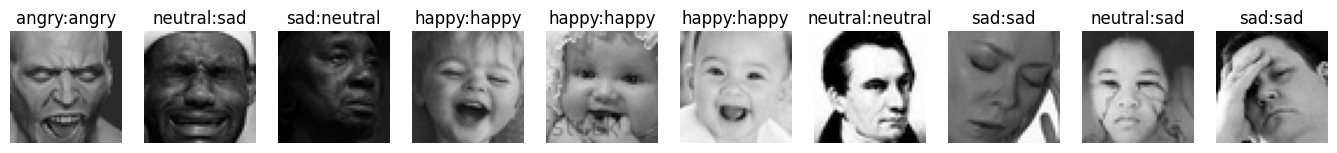

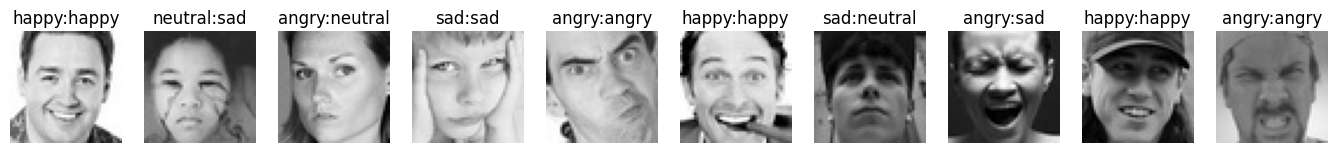

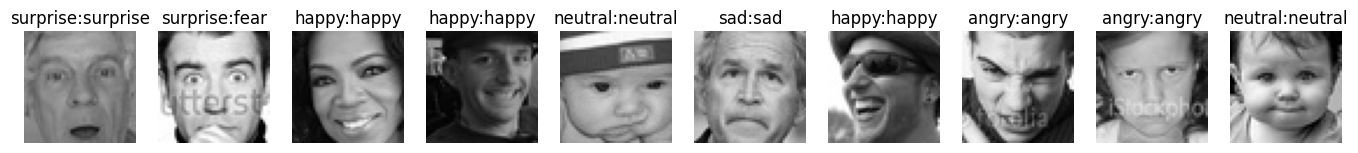

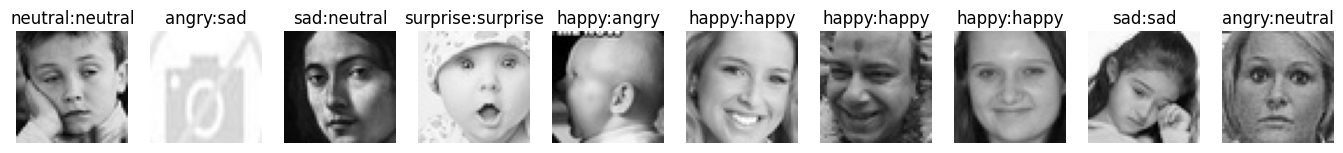

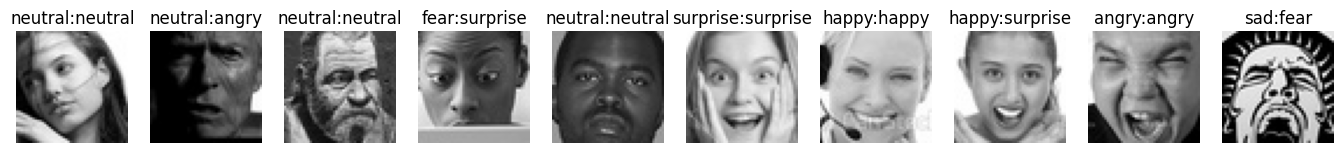

In [29]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(15)
fig=plt.figure(figsize=(15,15))

counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        label_class = int(labels[ii])
        sub.set_title(str(classes[index]) + ":" + classes[label_class])
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

## Confusion Matrix

In [30]:
actual = []
predicted = []

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(3000)
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    res = int(labels[ii])
    label_class = int(labels[ii])
    actual.append(classes[label_class])
    predicted.append(str(classes[index]))

In [31]:
print(actual[20])
print(predicted[20])

surprise
surprise


In [32]:
cnf_matrix = confusion_matrix(actual, predicted)

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(4, 4),frameon =False, dpi=200)  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[217   3  42  21  48  61  12]
 [  9  27   3   0   1   3   1]
 [ 48   2 203  14  41  71  30]
 [ 21   0  12 643  21  21  13]
 [ 38   0  40  42 322  80   8]
 [ 78   0  72  30  81 278   9]
 [ 10   0  20  12  16  10 266]]


<Figure size 640x480 with 0 Axes>

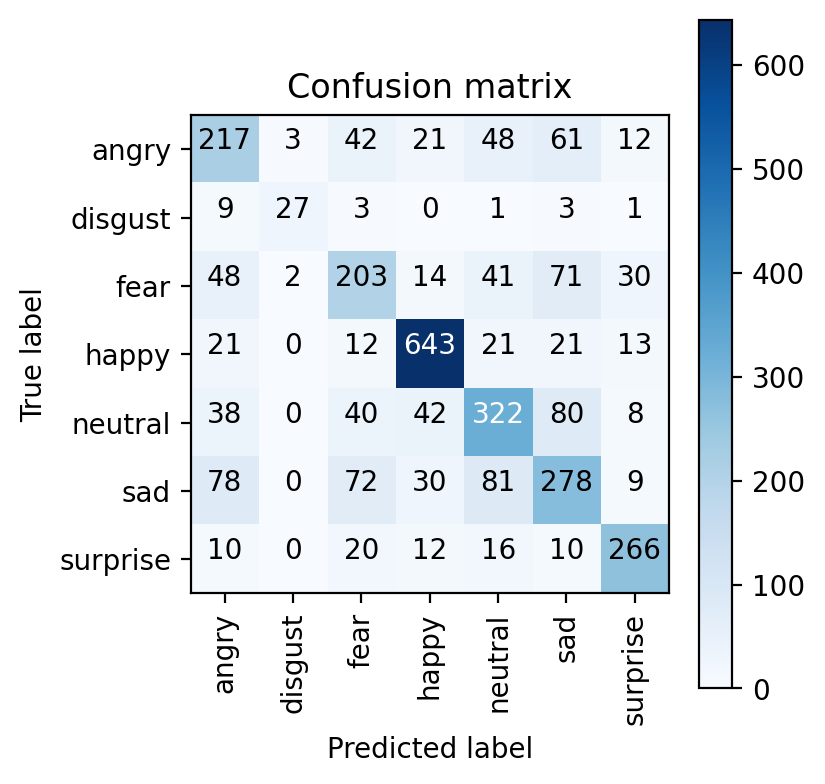

Normalized confusion matrix
[[0.53712871 0.00742574 0.1039604  0.0519802  0.11881188 0.1509901
  0.02970297]
 [0.20454545 0.61363636 0.06818182 0.         0.02272727 0.06818182
  0.02272727]
 [0.11735941 0.00488998 0.49633252 0.03422983 0.1002445  0.17359413
  0.07334963]
 [0.02872777 0.         0.01641587 0.87961696 0.02872777 0.02872777
  0.01778386]
 [0.07169811 0.         0.0754717  0.07924528 0.60754717 0.1509434
  0.01509434]
 [0.14233577 0.         0.13138686 0.05474453 0.14781022 0.50729927
  0.01642336]
 [0.02994012 0.         0.05988024 0.03592814 0.04790419 0.02994012
  0.79640719]]


<Figure size 640x480 with 0 Axes>

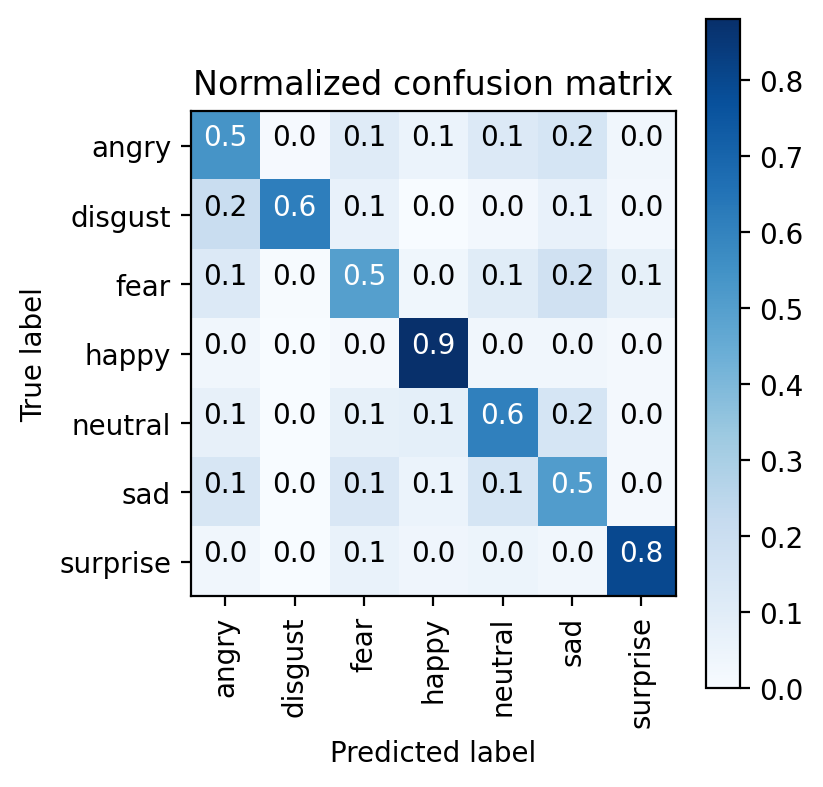

              precision    recall  f1-score   support

       angry       0.52      0.54      0.53       404
     disgust       0.84      0.61      0.71        44
        fear       0.52      0.50      0.51       409
       happy       0.84      0.88      0.86       731
     neutral       0.61      0.61      0.61       530
         sad       0.53      0.51      0.52       548
    surprise       0.78      0.80      0.79       334

    accuracy                           0.65      3000
   macro avg       0.66      0.63      0.65      3000
weighted avg       0.65      0.65      0.65      3000

0.652


In [34]:
# Plot non-normalized confusion matrix
plt.figure()
class_names = classes
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

print(classification_report(actual, predicted, target_names=class_names))

print(accuracy_score(actual, predicted))